# Markov Chain Monte Carlo (MCMC)

Sources:

https://people.duke.edu/~ccc14/sta-663-2018/notebooks/S10_AbbreviatedNotes.html

https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

https://www.youtube.com/watch?v=oX2wIGSn4jY

Markov Chain Monte Carlo (MCMC) is a computational method used for sampling from complex probability distributions, especially when direct sampling or analytical methods are not feasible.

With MCMC, we draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e., the samples form a Markov chain). Under certain conditions, the Markov chain will have a unique stationary distribution. In addition, not all samples are used - instead we set up acceptance criteria for each draw based on comparing successive states with respect to a target distribution that ensure that the stationary distribution is the posterior distribution of interest. The nice thing is that this target distribution only needs to be proportional to the posterior distribution, which means we don’t need to evaluate the potentially intractable marginal likelihood, which is just a normalizing constant. We can find such a target distribution easily, since, according to Bayes' theorem, `posterior ∝ likelihood x prior`. After some time, the Markov chain of accepted draws will converge to the stationary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution in the same way as for the standard Monte Carlo integration.

To carry out the <ins>Metropolis-Hastings algorithm</ins>, we need to draw random samples from the following distributions

- the standard uniform distribution
- a proposal distribution $g(x)$
- the target distribution $f(x)$ which is proportional to the posterior probability

This is the description of the simpler Metropolis algorithm (symmetric proposal distribution). Let $f(x)$ be a function that is proportional to the desired probability density function $P(x)$ (a.k.a. a target distribution):

Step 1 -- Initialization: Choose an arbitrary point $x_{t}$ to be the first observation in the sample and choose a proposal function $g(x\mid y)$. The latter means that new candidates is characterized by the probability distribution
$g(x\mid y)$ of a new proposed sample $x$ given the previous sample $y$. In this first example, $g$ is assumed to be symmetric; in other words, it must satisfy $g(x\mid y)=g(y\mid x)$.


Step 2 -- For each iteration t:

- Propose a candidate $x^\prime$ for the next sample by picking from the distribution $g(x'\mid x_{t})$.
- Calculate the acceptance ratio $\alpha =f(x^\prime)/f(x_{t})$, which will be used to decide whether to accept or reject the candidate. Because $f$ is proportional to the density of $P$, we have that $\alpha=f(x^\prime)/f(x_{t})=P(x^\prime)/P(x_{t})$.

- Accept or reject: Generate a uniform random number $u\in [0,1]$.

- If $u\leq \alpha$, then accept the candidate by setting $x_{t+1}=x^\prime$,

- If $u>\alpha$, then reject the candidate and set $x_{t+1}=x_{t}$ instead.

This algorithm proceeds by randomly attempting to move about the sample space, sometimes accepting the moves and sometimes remaining in place. Note that the acceptance ratio $\alpha$ indicates how probable the new proposed sample is with respect to the current sample, according to the distribution whose density is $P(x)$. If we attempt to move to a point that is more probable than the existing point (i.e., a point in a higher-density region of $P(x)$ corresponding to an $\alpha >1\geq u$), we will always accept the move. However, if we attempt to move to a less probable point, we will sometimes reject the move, and the larger the relative drop in probability, the more likely we are to reject the new point.


The Metropolis algorithm can be extended o the Metropolis-Hastings in which the acceptance criterion is modified by

\begin{equation}
u \leq \frac{f(x_{t+1})}{f(x_t)} \frac{g(x_t|x_{t+1})}{g(x_{t+1}|x_{t})}
\end{equation}

The ratio $g(x_t|x_{t+1})/g(x_{t+1}|x_{t})$ is equal to 1 if the proposal density is symmetric. These extra terms ensure reversibility for asymmetric $g$, e.g., if one is more likely to propose to go from $x_t$ to $x_{t+1}$ than the reverse.

<b>Example 1:</b> Using MCMC to generate standard normal samples from uniform samples.

- The proposal density $g(x)$ is uniform on an interval centered at current state (hence symmetrical)
- The target density $f(x)$ is $N(0,1)$ which is proportional to $e^{-x^2/2}$
- The acceptance ratio $\alpha$ is

\begin{equation}
\frac{e^{-x_{k+1}^2/2}}{e^{-x_k^2/2}} = e^{-(x_{k+1}^2- x_k^2)/2}
\end{equation}

where $k$ labels the iterations.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Text(0, 0.5, 'Probability')

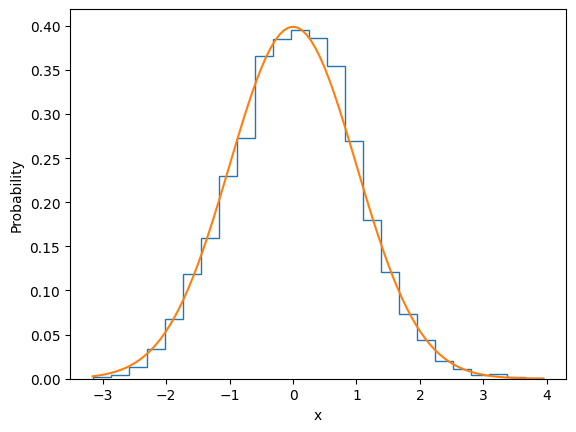

In [3]:
# Metropolis algorithm (symmetric proposal distribution)

n = 10000
xs = np.zeros(n)
x = 0
for i in range(n):
    xp = np.random.uniform(x-1, x+1)
    alpha = np.exp(-(xp**2-x**2)/2)
    r = np.random.rand()
    if r < alpha:
        x = xp
    xs[i] = x

plt.hist(xs, 25, histtype='step', density=True)
xf = np.linspace(xs.min(), xs.max(), 100)
plt.plot(xf, stats.norm().pdf(xf))
plt.xlabel('x')
plt.ylabel('Probability')

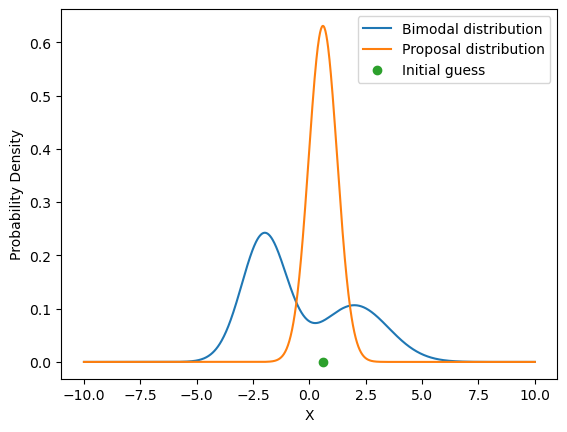

In [ ]:
# Let's build from a more complicated target distribution

# Function to generate bimodal (target) distribution (this is normalized!)
def bimodal_distribution(x, params1, params2):
    mean1, std1, weight1 = params1
    mean2, std2, weight2 = params2
    gaussian1 = (weight1/(np.sqrt(2*np.pi)*std1)) * np.exp(-(x - mean1)**2 / (2 * std1**2))
    gaussian2 = (weight2/(np.sqrt(2*np.pi)*std2))  * np.exp(-(x - mean2)**2 / (2 * std2**2))

    return gaussian1 + gaussian2

# Parameters for the bimodal distribution (target)
x = np.linspace(-10, 10, 1000)
mean1, std1, weight1 = -2, 1, 0.6
params1 = [mean1, std1, weight1]

mean2, std2, weight2 = 2, 1.5, 0.4
params2 = [mean2, std2, weight2]

bimodal_data = bimodal_distribution(x, params1, params2)

# Parameters for the Gaussian distribution (proposal)
mean = 0.6
std = np.sqrt(0.4)

proposal = stats.norm.pdf(x, loc=mean, scale=std)

# Plot the bimodal (target) with the proposal distribution
plt.plot(x, bimodal_data, label='Bimodal distribution')
plt.plot(x, proposal, label='Proposal distribution')
plt.plot(mean,0,'o', label='Initial guess')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

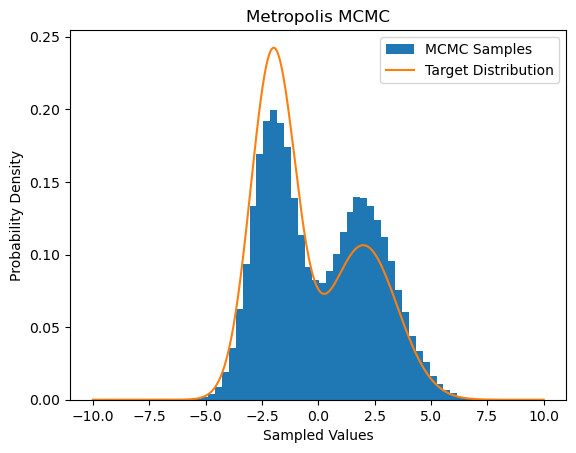

In [ ]:
# Function to generate bimodal distribution
def target_distribution(x, params1, params2):
    mean1, std1, weight1 = params1
    mean2, std2, weight2 = params2
    gaussian1 = weight1 * np.exp(-(x - mean1)**2 / (2 * std1**2))
    gaussian2 = weight2 * np.exp(-(x - mean2)**2 / (2 * std2**2))

    return gaussian1 + gaussian2

# Generate data for the bimodal distribution
x = np.linspace(-10, 10, 1000)
mean1, std1, weight1 = -2, 1, 0.6
params1 = [mean1, std1, weight1]

mean2, std2, weight2 = 2, 1.5, 0.4
params2 = [mean2, std2, weight2]

# Metropolis algorithm for MCMC
def metropolis(x_current, params1 , params2, proposal_std):

    # Propose a new sample from a normal distribution
    x_proposed = x_current + np.random.normal(scale=proposal_std)

    # Calculate the acceptance ratio
    acceptance_ratio = min(1, target_distribution(x_proposed, params1, params2) / target_distribution(x_current, params1, params2))

    # Accept or reject the proposed sample
    if np.random.rand() < acceptance_ratio:
        return x_proposed
    else:
        return x_current

# Function to run the MCMC chain
def run_mcmc(initial_position, num_samples, params1, params2, proposal_std):
    samples = [initial_position]
    current_position = initial_position

    for _ in range(num_samples - 1):
        current_position = metropolis(current_position, params1, params2, proposal_std)
        samples.append(current_position)

    return np.array(samples)

# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
num_samples = 100000
initial_position = 0.6
proposal_std = np.sqrt(0.4)

# Run MCMC chain
samples = run_mcmc(initial_position, num_samples, params1, params2, proposal_std)

# Plot the MCMC samples and the target distribution
plt.hist(samples, bins=50, density=True, label='MCMC Samples')
plt.plot(x, bimodal_distribution(x, params1, params2), label='Target Distribution')
plt.legend()
plt.title('Metropolis MCMC')
plt.xlabel('Sampled Values')
plt.ylabel('Probability Density')
plt.show()

In [6]:
np.sum(0/25 + 1/36 + 4/64 + 9/49 + 16/81)

0.4714821113630637

In [10]:
A=np.array([[0.116,0.165],[0.165,0.471]])
B=np.array([5,10])
np.linalg.solve(A,B)

array([25.71960162, 12.22137098])

C:\Users\cgroc\AppData\Local\Temp\ipykernel_8300\2305983584.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return (x ** (df / 2 - 1) * np.exp(-x / 2)) / (2 ** (df / 2) * np.math.gamma(df / 2))


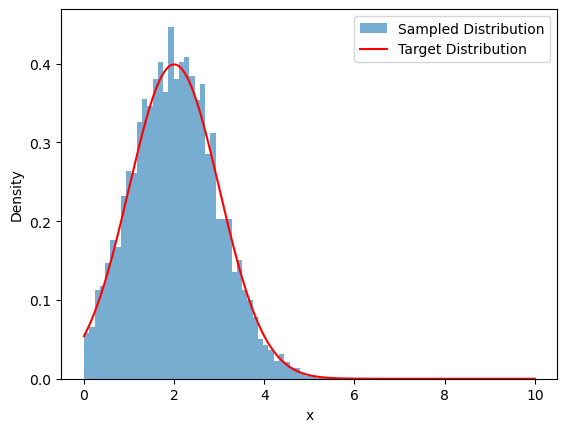

In [ ]:
# Let's try the generalized Metropolis-Hastings algorithm with an asymmetric proposal distribution

# Target distribution: shifted normal distribution (mean = 2, std = 1)
def target_distribution(x, mean=2, std=1):
    return np.exp(-((x - mean) ** 2) / (2 * std ** 2)) / (np.sqrt(2 * np.pi) * std)

# Asymmetric proposal distribution: chi-squared distribution
def proposal_distribution(df=2):
    return np.random.chisquare(df)

# Proposal distribution PDF for correction term g(x'|x) for chi-squared distribution
def proposal_pdf_chisquare(x, df=2):
    return (x ** (df / 2 - 1) * np.exp(-x / 2)) / (2 ** (df / 2) * np.math.gamma(df / 2))

# Metropolis-Hastings algorithm with chi-squared proposal
def metropolis_hastings(n_samples, initial_x, df=2, target_mean=2, target_std=1):
    samples = [initial_x]
    current_x = initial_x

    for _ in range(n_samples):
        proposed_x = proposal_distribution(df=df)

        # Calculate the acceptance ratio
        target_ratio = target_distribution(proposed_x, mean=target_mean, std=target_std) / target_distribution(current_x, mean=target_mean, std=target_std)

        # Asymmetry correction for the chi-squared proposal
        proposal_ratio = proposal_pdf_chisquare(current_x, df=df) / proposal_pdf_chisquare(proposed_x, df=df)

        acceptance_ratio = target_ratio * proposal_ratio

        # Accept or reject the proposed move
        if np.random.rand() < acceptance_ratio:
            current_x = proposed_x

        samples.append(current_x)

    return np.array(samples)

# Parameters
n_samples = 10000
initial_x = 1.0
df = 2  # Degrees of freedom for chi-squared distribution
target_mean = 2  # Mean of the target shifted normal distribution
target_std = 1  # Standard deviation of the target shifted normal distribution

# Run the Metropolis-Hastings sampling
samples = metropolis_hastings(n_samples, initial_x, df=df, target_mean=target_mean, target_std=target_std)

# Plot the samples
plt.hist(samples, bins=50, density=True, alpha=0.6, label="Sampled Distribution")

# Plot the target distribution (shifted normal)
x = np.linspace(0, 10, 1000)
plt.plot(x, target_distribution(x, mean=target_mean, std=target_std), label="Target Distribution", color="red")
plt.xlabel('x')
plt.ylabel('Density')

plt.legend()
plt.show()


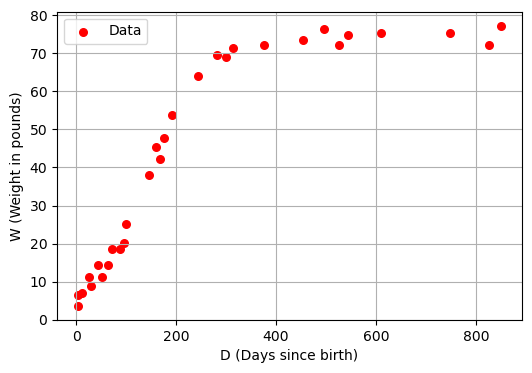

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# This is just to generate data to test the MCMC
# This data is based on the dataset "wilson" which reported data on the weight of the puppy
# Wilson as he grew. We did not download the data but we created this code to generate a synthetic
# data based on the features of the original data.
# Source: https://jmzobitz.github.io/ModelingWithR/metropolis-12.html

# Parameters (we pretend we do not know p1)
p1 = 75
p2 = 2.461935
p3 = 0.017032

# Generate random, non-uniformly spaced D values (more points for small D, fewer for large D)
np.random.seed(34)  # Setting seed for reproducibility
D = np.sort(np.random.exponential(scale=300, size=30))  # Exponential distribution to reduce points at higher D

# Clip D values to stay within 0 to 1600
D = np.clip(D, 0, 1600)

# Define the function W(D)
def weight_function(D, p1, p2=2.461935,p3=0.017032):
    '''Weight function of the puppy Wilson'''
    '''The function returns the weight in pounds and D is number of days since birth'''
    return p1 / (1 + np.exp(p2 - p3 * D))

# Generate weights using the function
weights = weight_function(D, p1, p2, p3)

# Add noise to the weights (Gaussian noise with mean 0 and standard deviation sigma)
sigma = 2
noise = np.random.normal(0, sigma, size=weights.shape)
weights_noisy = weights + noise

# Create a DataFrame to hold the data
data = pd.DataFrame({'Days': D, 'Weight': weights_noisy})

# Plot the synthetic data
plt.figure(figsize=(6, 4))
plt.scatter(data['Days'], data['Weight'], color='red', label='Data', s=30)
plt.xlabel('D (Days since birth)')
plt.ylabel('W (Weight in pounds)')
plt.grid(True)
plt.legend()
plt.show()


Let $W$ be Wilson's weight in pounds and $D$ be the days since its birth. The model that describes Wilson's weight over time is

\begin{equation}
W = f(D,p_1,p_2,p_3) = \frac{p_1}{1+\exp(p_2-p_3 D)}
\end{equation}

with $\theta = \{p_1,p_2,p_3\}$ the parameters of the model. For the sake of illustrating the approach, let's consider we already know the values of $p_2=2.461935$ and $p_3=0.017032$ and wish to estimate $p_1$ with MCMC. In this model, $p_1$ represents the long-term weight for Wilson.

Let's make an initial guess for $p_1=78$. Then, let's try another guess for $p_1 = 65$. From these two parameter samplings, which model of $p_1$ represents the data better? <b>How to select a model for $p_1$?</b>

<b>Likelihood Ratios for Parameter Estimation</b>

We will need the likelihood function that links the model to the data. We are assuming that the data are all independent and identically distributed, resulting in the following likelihood

\begin{equation}
\mathcal{L}(p_1) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left\{-\frac{[W_i-f(D_i,p_1)]^2}{2\sigma^2}   \right\}
\end{equation}

and we will pick $p_1$ that maximizes the likelihood.

In [ ]:
# Function to compute the log-likelihood
def compute_likelihood(data, p1):
    # Get model predictions using the weight function
    predicted_weights = weight_function(data['Days'], p1)

    # Compute residuals (difference between observed and predicted values)
    residuals = data['Weight'] - predicted_weights

    # Compute Gaussian log-likelihood (sigma = 1)
    log_likelihood = -0.5 * np.sum(residuals**2)

    return log_likelihood

first_guess = compute_likelihood(data, p1=78)
second_guess = compute_likelihood(data, p1=65)

print('log-likelihood:', first_guess, second_guess)

log-likelihood: -110.80222715999733 -762.8480365408265


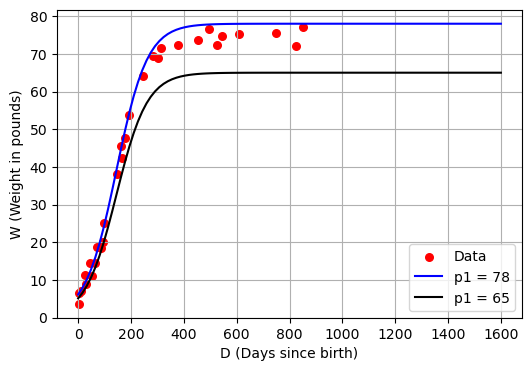

In [ ]:
# Plot the different models given p1
x = np.linspace(0,1600,100)
y1 = weight_function(x, p1=78)
y2 = weight_function(x, p1=65)
plt.figure(figsize=(6, 4))
plt.scatter(data['Days'], data['Weight'], color='red', label='Data', s=30)
plt.plot(x,y1,'b-',label='p1 = 78')
plt.plot(x,y2,'k-',label='p1 = 65')
plt.xlabel('D (Days since birth)')
plt.ylabel('W (Weight in pounds)')
plt.grid(True)
plt.legend()
plt.show()

<b>From the values above, which one to pick?</b>

The one that maximizes the log-likelihood!

We can re-write the acceptance ratio for a given set of parameters $\vec{\theta}$ in terms of the log-likelihood. This can be done by just exponentiating the log-likelihood from the equation

\begin{equation}
\alpha = \frac{T_{new}(\vec{\theta}^{\,\prime})}{T_{old}(\vec{\theta})}
\end{equation}

$T$ is the target distribution, proportional to the posterior, which includes the likelihood and the prior. Then, we can write the ratio as

\begin{equation}
\alpha = e^{\{\log{(\mathcal{L}_{new})} - \log{(\mathcal{L}_{old})}\}}
\end{equation}


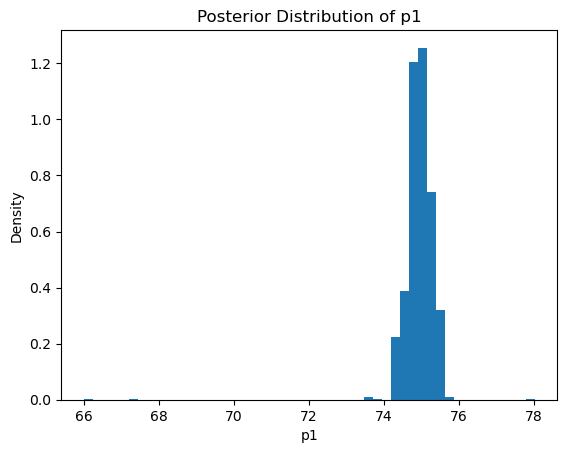

Mean of p1: 74.9474
95% credible interval for p1: [74.39959216 75.47554992]


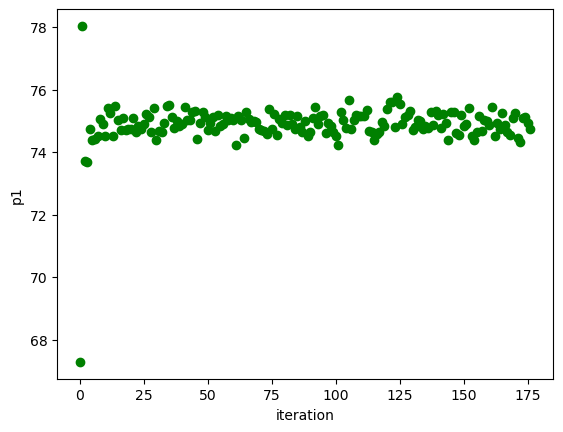

In [ ]:
# Define the log-likelihood function
def log_likelihood(data, p1):
    predicted_weights = weight_function(data['Days'], p1)
    # Assuming a Gaussian likelihood with sigma = 1
    sigma = 1.0  # Standard deviation of the observations
    log_likelihoods = -0.5 * np.sum(((data['Weight'] - predicted_weights) / sigma)**2)
    return log_likelihoods

# Define the MCMC Metropolis-Hastings function
def metropolis_hastings(data, initial_p1, iterations, proposal_width):
    p1_samples = []
    p1_accepted = []
    p1_rejected = []
    likelihood_history = []

    p1_current = initial_p1
    likelihood_current = log_likelihood(data, p1_current)

    for _ in range(iterations):
        # Propose a new value for p1
        p1_proposed = np.random.normal(p1_current, proposal_width)

        # Calculate the likelihood for the proposed value
        likelihood_proposed = log_likelihood(data, p1_proposed)

        # Calculate acceptance probability
        acceptance_ratio = np.exp(likelihood_proposed - likelihood_current)

        # Accept or reject the proposed value
        if np.random.rand() < acceptance_ratio:
            p1_current = p1_proposed
            likelihood_current = likelihood_proposed
            p1_accepted.append(p1_proposed)

        else:
            p1_rejected.append(p1_proposed)

        p1_samples.append(p1_current)
        likelihood_history.append(likelihood_current)

    return np.array(p1_samples), np.array(p1_accepted), np.array(p1_rejected), likelihood_history

# Parameters for MCMC
initial_p1 = 66  # Initial guess for p1
iterations = 10000  # Number of iterations
proposal_width = 20  # Width of the proposal distribution

# Run MCMC method
p1_samples, p1_accepted, p1_rejected, likelihood_history = metropolis_hastings(data, initial_p1, iterations, proposal_width)

# Plotting the posterior distribution
plt.figure()
plt.hist(p1_samples, bins=50, density=True)
plt.title('Posterior Distribution of p1')
plt.xlabel('p1')
plt.ylabel('Density')
plt.show()

plt.figure()
plt.plot(p1_accepted, 'go', label="accepted")
#plt.plot(p1_rejected, 'rx', label='rejected')
plt.ylabel("p1")
plt.xlabel("iteration")

# Calculate mean and credible intervals
p1_mean = np.mean(p1_samples)
p1_cred_int = np.percentile(p1_samples, [2.5, 97.5])

print(f"Mean of p1: {p1_mean:.4f}")
print(f"95% credible interval for p1: {p1_cred_int}")

C:\Users\cgroc\AppData\Local\Temp\ipykernel_8300\2795184494.py:32: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(log_acceptance_ratio)


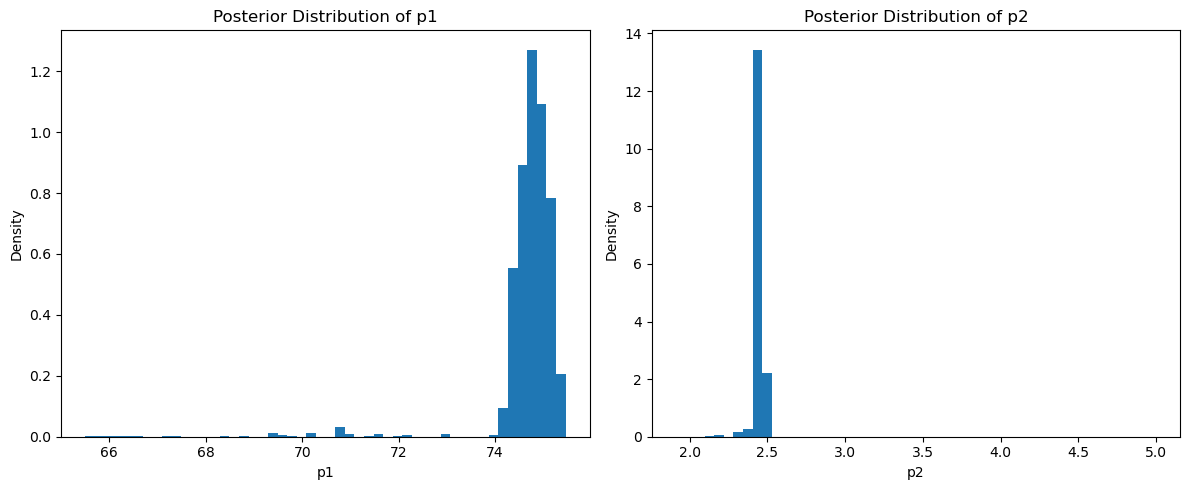

Acceptance rate: 0.0267
Mean of p1: 74.6854
95% credible interval for p1: [73.9420988  75.31638109]
Mean of p2: 2.4430
95% credible interval for p2: [2.39777975 2.48151727]


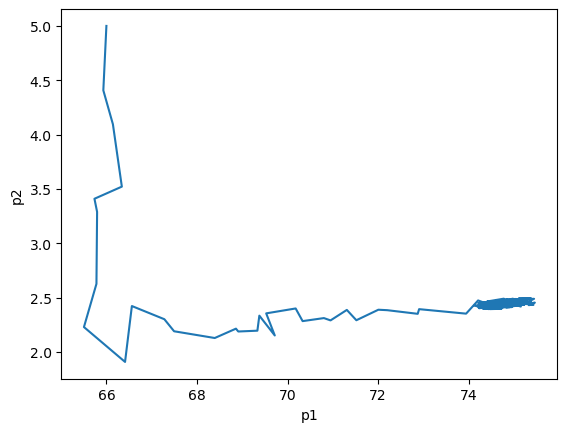

In [ ]:
# Define the weight function with both p1 and p2 as parameters
def weight_function(D, p1, p2, p3=0.017032):
    return p1 / (1 + np.exp(p2 - p3 * D))

# Define the log-likelihood function
def log_likelihood(data, p1, p2):
    predicted_weights = weight_function(data['Days'], p1, p2)
    sigma = 1.0  # Standard deviation of the observations
    return -0.5 * np.sum(((data['Weight'] - predicted_weights) / sigma) ** 2)

# Define the MCMC Metropolis-Hastings function for p1 and p2
def metropolis_hastings(data, initial_p1, initial_p2, iterations, proposal_width_p1, proposal_width_p2):
    p1_samples = []
    p2_samples = []

    p1_current = initial_p1
    p2_current = initial_p2
    log_likelihood_current = log_likelihood(data, p1_current, p2_current)

    acceptances = 0  # To track acceptance rate

    for _ in range(iterations):
        # Propose new values for p1 and p2
        p1_proposed = np.random.normal(p1_current, proposal_width_p1)
        p2_proposed = np.random.normal(p2_current, proposal_width_p2)

        # Calculate the log-likelihood for the proposed values
        log_likelihood_proposed = log_likelihood(data, p1_proposed, p2_proposed)

        # Calculate the acceptance probability in terms of log-likelihood
        log_acceptance_ratio = log_likelihood_proposed - log_likelihood_current
        acceptance_ratio = np.exp(log_acceptance_ratio)

        # Accept or reject the proposed values
        if np.random.rand() < min(1, acceptance_ratio):
            p1_current = p1_proposed
            p2_current = p2_proposed
            log_likelihood_current = log_likelihood_proposed
            acceptances += 1  # Count accepted proposals

        # Store the current p1 and p2 values
        p1_samples.append(p1_current)
        p2_samples.append(p2_current)

    acceptance_rate = acceptances / iterations
    return np.array(p1_samples), np.array(p2_samples), acceptance_rate

# Parameters for MCMC
initial_p1 = 66  # Initial guess for p1
initial_p2 = 5.0  # Initial guess for p2
iterations = 10000  # Number of iterations
proposal_width_p1 = 0.5 #5.0 #1.0 #0.1  # Proposal width for p1
proposal_width_p2 = 0.5 #5.0 #1.0 #0.1  # Proposal width for p2

# Run MCMC to estimate p1 and p2
p1_samples, p2_samples, acceptance_rate = metropolis_hastings(
    data, initial_p1, initial_p2, iterations, proposal_width_p1, proposal_width_p2
)

# Plotting the posterior distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(p1_samples, bins=50, density=True)
plt.title('Posterior Distribution of p1')
plt.xlabel('p1')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(p2_samples, bins=50, density=True)
plt.title('Posterior Distribution of p2')
plt.xlabel('p2')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.array(p1_samples), np.array(p2_samples))
plt.xlabel('p1')
plt.ylabel('p2')

# Calculate mean and credible intervals for p1 and p2
p1_mean = np.mean(p1_samples)
p2_mean = np.mean(p2_samples)

p1_cred_int = np.percentile(p1_samples, [2.5, 97.5])
p2_cred_int = np.percentile(p2_samples, [2.5, 97.5])

print(f"Acceptance rate: {acceptance_rate:.4f}")
print(f"Mean of p1: {p1_mean:.4f}")
print(f"95% credible interval for p1: {p1_cred_int}")
print(f"Mean of p2: {p2_mean:.4f}")
print(f"95% credible interval for p2: {p2_cred_int}")


<b>Autocorrelation for the parameters</b>

Another critical diagnostic when running MCMC is to analyze the convergence of the parameters in the Markov Chain through the computation of correlations. This will allow the analysis of the spread of the parameters compared to their final result. If the parameters are spread around randomly, then their correlation coefficient will be close to zero. If the parameters are biased to one side, i.e. the parameter updates are mostly going in one specific direction, then there will be a strong correlation in the trend of the parameters.

To examine this quantitatively, we can use the autocorrelation for the paramater $\theta_i$ in its $i$-th iteration as

\begin{equation}
\rho_k = \frac{\sum_{t=k+1}^n (\theta_t - \bar{\theta})(\theta_{t-k}-\bar{\theta})}{\sum_{t=1}^n (\theta_t-\bar{\theta})^2}
\end{equation}

which describes the correlation between observations of a time series at two points in time, separated by a specific lag $k$. Essentially, it quantifies how a value in the time series is related to its previous values. In summary, the quantities in the equation above are:

- $\rho_k$: autocorrelation at lag $k$
- $\theta_t$: value of the series at time $t$
- $\bar{\theta}$: mean of the series
- $n$: number of observations

The autocorrelation is just the correlation of an event with a previous event that is separated by some number of steps (the lag). In general terms, it can indicate the degree of similarity of a time series compared to lagged versions of the same data series. In the ideal scenario, we should see that the autocorrelation falling exponentially as $\rho(t) \sim e^{-t/\tau}$ with some decay rate $\tau$ and the approach to convergence indicated by an autocorrelation tending to zero.

74.93727364231826 2.446318390680771


[Text(0.5, 0, 'lag'), Text(0, 0.5, 'autocorrelation'), (-1.0, 1.0)]

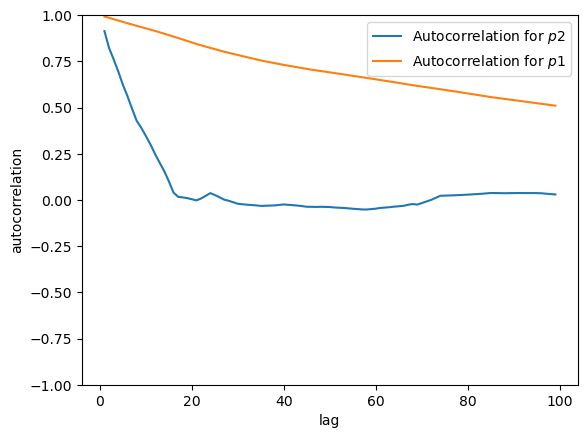

In [ ]:
#from statsmodels.graphics.tsaplots import plot_acf
#plot_acf(p1_samples, lags=100)
#plot_acf(p2_samples, lags=100)
#data: your time series
#lags: number of 'periods' you will like to investigate

mean_acc_p1=p1_samples[-100:].mean()
mean_acc_p2=p2_samples[-100:].mean()
print(mean_acc_p1,mean_acc_p2)


def autocorr(p1_samples, p2_samples, lag):
    num_p1=0
    denom_p1=0
    num_p2=0
    denom_p2=0
    rk_p1,rk_p2 = 0, 0
    for i in range(len(p1_samples)-lag):
        num_p1+=(p1_samples[i]-mean_acc_p1)*(p1_samples[i+lag]-mean_acc_p1)
        num_p2+=(p2_samples[i]-mean_acc_p2)*(p2_samples[i+lag]-mean_acc_p2)
        denom_p1+=(mean_acc_p1-p1_samples[i])**2
        denom_p2+=(mean_acc_p2-p2_samples[i])**2
    if denom_p1 > 0 and denom_p2 > 0:
        rk_p1=num_p1/denom_p1
        rk_p2=num_p2/denom_p2
    return rk_p1, rk_p2

lag=np.arange(1,100)
result=np.zeros((2,lag.shape[0]))
for l in lag:
    result[:,l-1]=autocorr(p1_samples, p2_samples, l)


fig, ax = plt.subplots()
ax.plot(lag, result[1,:], label='Autocorrelation for $p2$')
ax.plot(lag, result[0,:], label='Autocorrelation for $p1$')
ax.legend(loc=0)
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-1, 1))

In [ ]:
!pip install corner

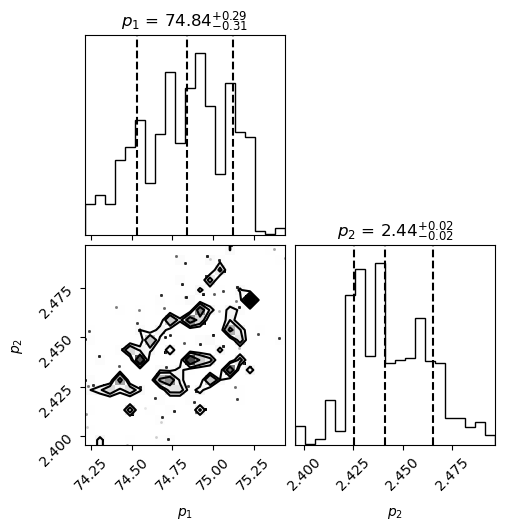

In [ ]:
import corner

# Prepare the data for the corner plot (combine p1 and p2 samples)
samples = np.vstack([p1_samples[-5000:-1], p2_samples[-5000:-1]]).T  # Transpose to have each parameter as a column

# Create a corner plot
figure = corner.corner(
    samples,
    labels=[r"$p_1$", r"$p_2$"],  # LaTeX-style labels for the parameters
    truths=[initial_p1, initial_p2],  # Optionally mark the initial guess
    show_titles=True,  # Show mean and 1-sigma title on each plot
    title_fmt=".2f",  # Formatting for the titles
    quantiles=[0.16, 0.5, 0.84],  # Display quantiles (1-sigma levels)
)

plt.show()